In [1]:
# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

In [ ]:
adata=sc.read_h5ad("/nfs/team283/yd2/WE_n3_scRNAseq_filt_cells_filt_genes_raw_counts_with_QC_and_annots_lvl5_20240404.h5ad")

In [ ]:
adata.obs['cell_type_lvl5'].unique().tolist()

In [ ]:
subtypes = ['meningeal fibroblast',
'dermal fibroblast FRZB+FOXF1+',
'dermal fibroblast FRZB+SIX2+',
'dermal fibroblast progenitor',
'limb fibroblast',
'limb myofibroblast',
'myofibroblast',
'fibroblast progenitors PDGFRA+',
'fibroblast progenitors PDGFRA+ZIC1+',
'fibroblast progenitors PDGFRA+ZIC1+FIBIN+',
'fibroblast progenitors PDGFRA+IRX2+',
'fibroblast progenitors PDGFRA+GATA6+',
'kidney fibroblast']

In [ ]:
fibro = adata[adata.obs.cell_type_lvl5.isin(subtypes), :]

In [ ]:
fibro.obs['cell_type_lvl5'].unique().tolist()

In [ ]:
li.mt.show_methods()

In [ ]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

In [ ]:
rank_aggregate.describe()

In [ ]:
# import all individual methods
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

In [ ]:
fibro.X[0,8]

In [ ]:
# log1p normalize the data
sc.pp.normalize_total(fibro)
fibro.X[0,8]

In [ ]:
sc.pp.log1p(fibro)
fibro.X[0,8]

In [ ]:
fibro

In [ ]:
fibro.raw = fibro

In [ ]:
fibro.raw.X[0,8]

In [88]:
# run cellphonedb
cellphonedb(fibro,
            groupby='cell_type_lvl5',
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name='consensus',
            expr_prop=0.1,
            verbose=True, key_added='cpdb_res')

Using `.raw`!
688 features of mat are empty, they will be removed.
/nfs/team283/yd2/software/my_miniconda3/envs/liana/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
Using resource `consensus`.
0.02 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 212068 samples and 1826 features


100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:46<00:00,  1.90it/s]


In [89]:
# by default, liana's output is saved in place:
fibro.uns['cpdb_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
69688,MDK,MDK,3.631195,0.999413,NCL,NCL,2.168719,0.993852,fibroblast progenitors PDGFRA+GATA6+,fibroblast progenitors PDGFRA+ZIC1+FIBIN+,2.899957,0.0
70353,MDK,MDK,3.620485,0.999813,NCL,NCL,2.168719,0.993852,fibroblast progenitors PDGFRA+IRX2+,fibroblast progenitors PDGFRA+ZIC1+FIBIN+,2.894602,0.0
61199,MDK,MDK,3.631195,0.999413,NCL,NCL,2.155725,0.985003,fibroblast progenitors PDGFRA+GATA6+,fibroblast progenitors PDGFRA+ZIC1+,2.893460,0.0
33243,MDK,MDK,3.631195,0.999413,NCL,NCL,2.149984,0.978508,fibroblast progenitors PDGFRA+GATA6+,fibroblast progenitors PDGFRA+,2.890590,0.0
52951,MDK,MDK,3.631195,0.999413,NCL,NCL,2.146403,0.992651,fibroblast progenitors PDGFRA+GATA6+,fibroblast progenitors PDGFRA+IRX2+,2.888799,0.0


In [90]:
fibro.uns['cpdb_res']['cellphone_pvals'].mean()

0.39846220502589524

In [114]:
# we import plotnine
import plotnine as p9
my_plot=li.pl.dotplot(adata = fibro,
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['dermal fibroblast FRZB+FOXF1+', 'dermal fibroblast FRZB+SIX2+'],
              target_labels=['meningeal fibroblast'],
              figure_size=(15, 8),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filter_fun=lambda x: (x['cellphone_pvals'] <= 0.05) & (x['lr_means'] >1.5),
              uns_key='cpdb_res', # uns_key to use, default is 'liana_res'
             )

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


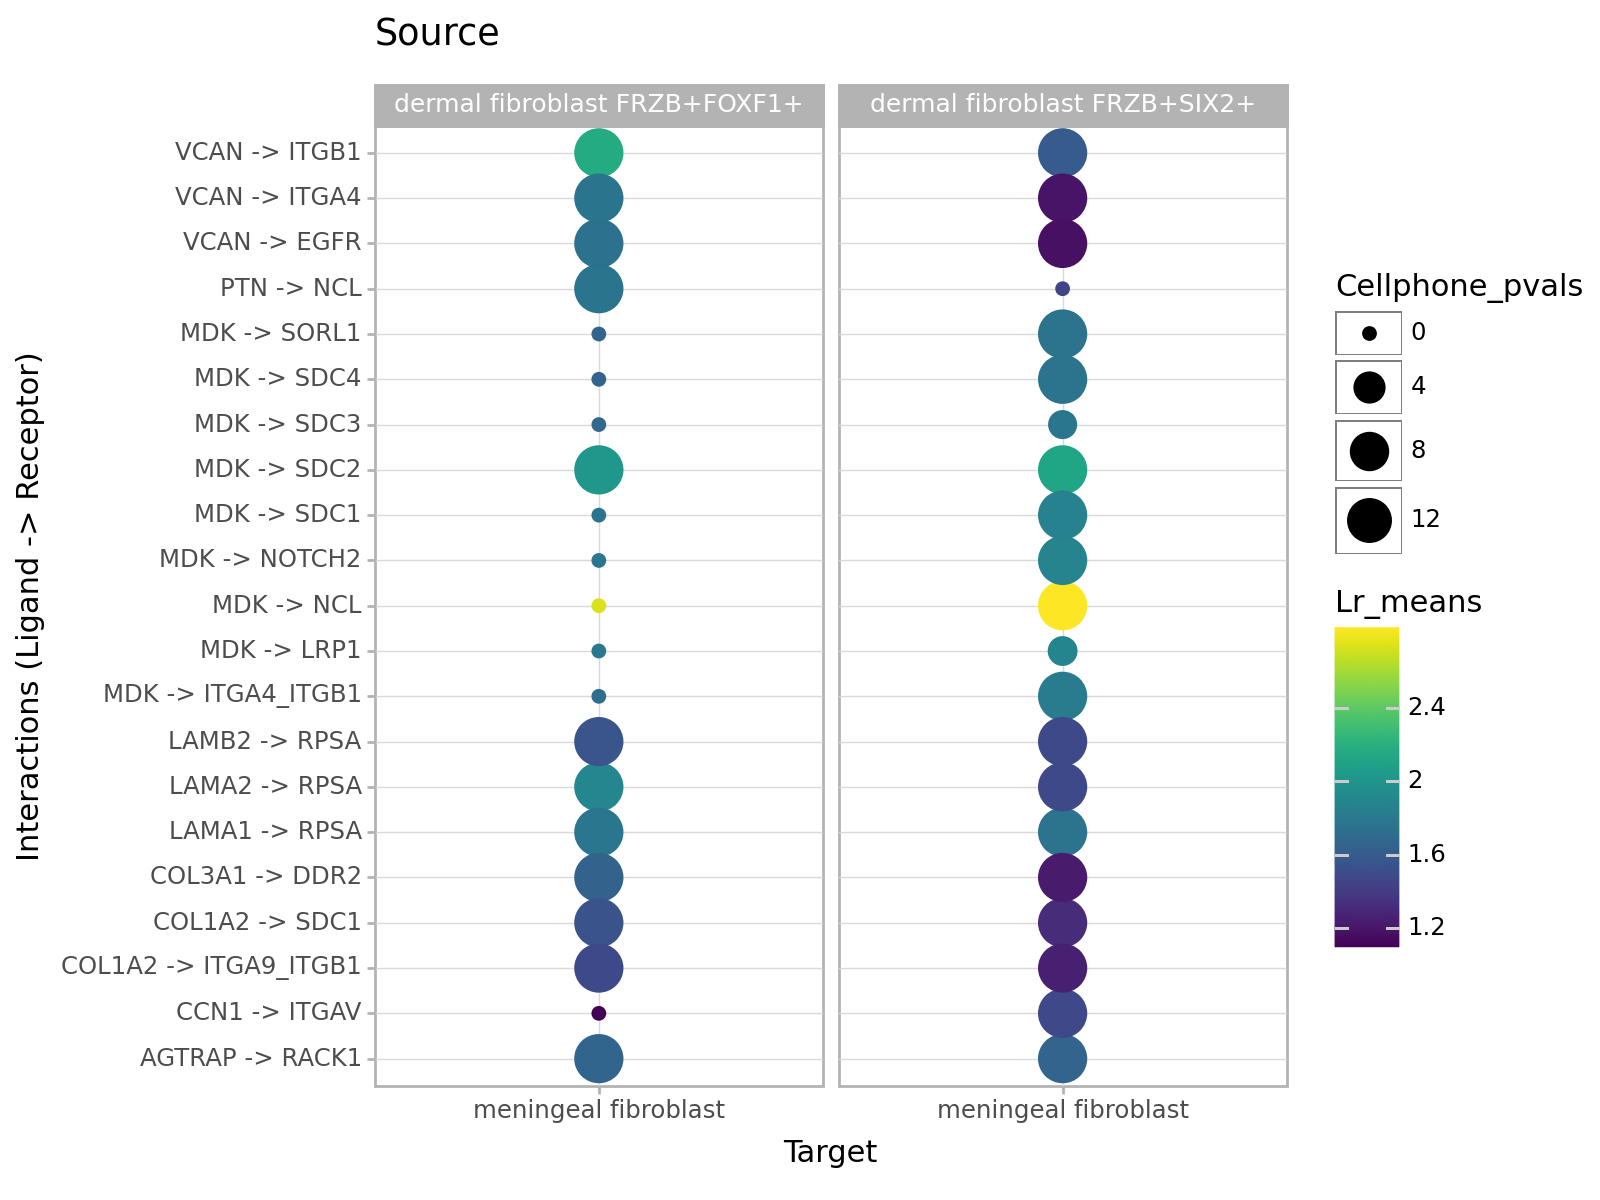

<Figure Size: (800 x 600)>

In [126]:
(my_plot +
 # change theme
 p9.theme_light() +
 # modify theme
 p9.theme(
     # adjust facet size
     strip_text=p9.element_text(size=9),
     figure_size=(8, 6)
 )
)

In [64]:
fibro[:,'MDK'].X.toarray().min()

0.0